In [15]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
data = pd.read_csv("Reduced_Train.csv")

In [17]:
# Drop the 'ID' column
df = data.drop(columns=['ID'])

# Drop rows with null values
df = df.dropna()


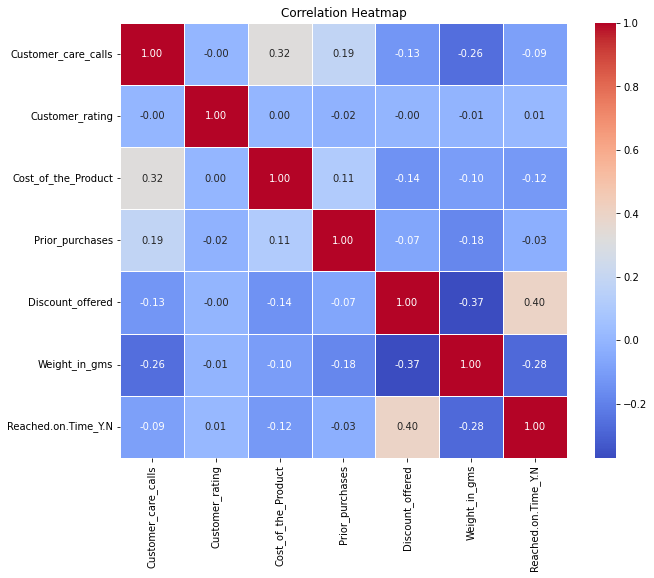

In [18]:
numeric_data = df.select_dtypes(include=['number'])

correlation_matrix = numeric_data.corr()


# Plot heatmap
plt.figure(figsize=(10, 8))  # Set the figure size
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Add title and show plot
plt.title('Correlation Heatmap')
plt.show()

Categorical Variables:
Index(['Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender'], dtype='object')
Numerical Variables:
['Customer_care_calls', 'Customer_rating', 'Cost_of_the_Product', 'Prior_purchases', 'Discount_offered', 'Weight_in_gms']
Customer_care_calls
Median 4.0
Mode 0    4
Name: Customer_care_calls, dtype: int64


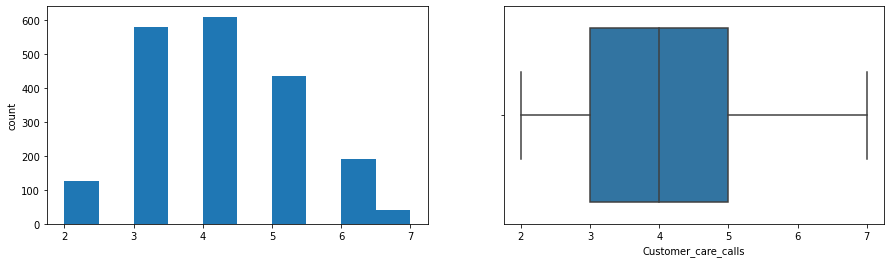

Customer_rating
Median 3.0
Mode 0    2
Name: Customer_rating, dtype: int64


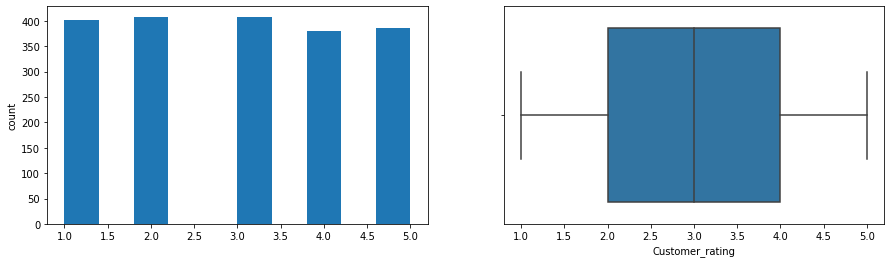

Cost_of_the_Product
Median 215.0
Mode 0    248
Name: Cost_of_the_Product, dtype: int64


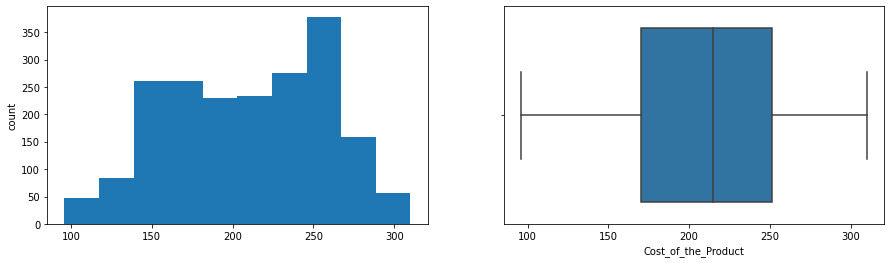

Prior_purchases
Median 3.0
Mode 0    3
Name: Prior_purchases, dtype: int64


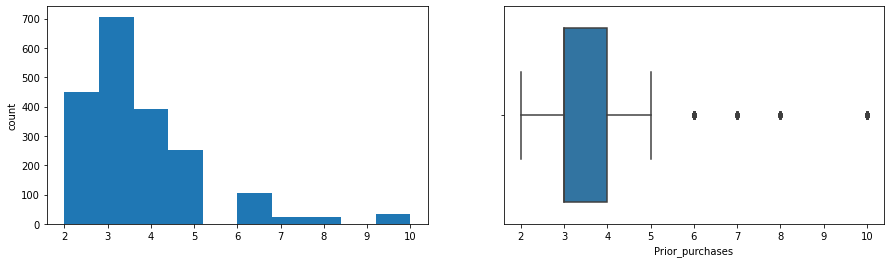

Discount_offered
Median 7.0
Mode 0    1
1    5
Name: Discount_offered, dtype: int64


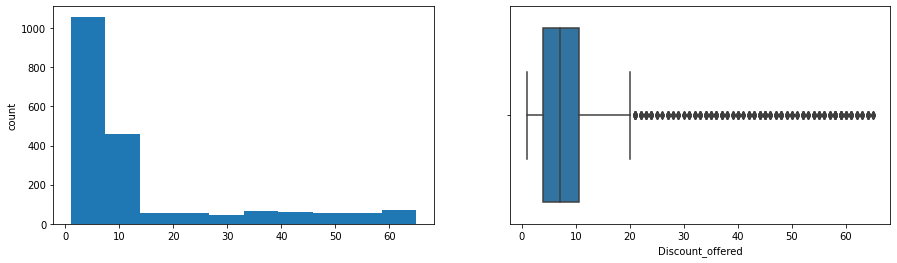

Weight_in_gms
Median 4070.0
Mode 0    1066.0
1    4883.0
Name: Weight_in_gms, dtype: float64


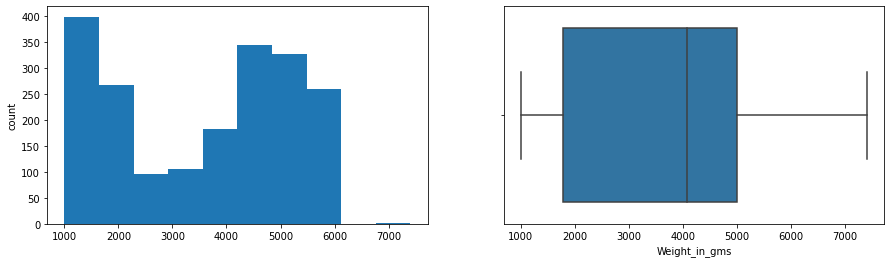

In [19]:
#CATEGORICAL AND NUMERIC COLUMNS

cat_cols=df.select_dtypes(include=['object']).columns
num_cols = df.select_dtypes(include=np.number).columns.tolist()
print("Categorical Variables:")
print(cat_cols)
print("Numerical Variables:")
num_cols.remove('Reached.on.Time_Y.N')
print(num_cols)
#UNIVARIATE NUMERIC ANALYSIS


for col in num_cols:

    print(col)
    print("Median",df[col].median())
    print("Mode",df[col].mode())
    plt.figure(figsize = (15, 4))
    plt.subplot(1, 2, 1)
    df[col].hist(grid=False)
    plt.ylabel('count')
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[col])
    plt.show()


In [20]:
X = df.drop(columns=["Reached.on.Time_Y.N"])
y = df["Reached.on.Time_Y.N"]

# Identify categorical and numerical features
categorical_features = ["Warehouse_block", "Mode_of_Shipment", "Product_importance", "Gender"]
numerical_features = ["Customer_care_calls", "Customer_rating", "Cost_of_the_Product", 
                       "Prior_purchases", "Discount_offered", "Weight_in_gms"]

In [21]:
# Preprocessing pipelines
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")), 
    ("scaler", StandardScaler())
])

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")), 
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer([
    ("num", num_pipeline, numerical_features),
    ("cat", cat_pipeline, categorical_features)
])

In [22]:
# Apply transformations
X_processed = preprocessor.fit_transform(X)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X_processed, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32).view(-1, 1)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

In [23]:
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define Neural Network Model using PyTorch
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.output(x))
        return x

In [24]:
input_size = X_train.shape[1]
model = NeuralNetwork(input_size)

# Define loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy for classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [28]:
loss_values = []

# Training loop with loss tracking
epochs = 400
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(train_loader)
    loss_values.append(avg_loss)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

# Evaluate model
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    test_predictions = (test_outputs > 0.5).float()
    accuracy = (test_predictions == y_test).float().mean()
    
print(f"Test Accuracy: {accuracy.item():.4f}")

Epoch [10/400], Loss: 0.2350
Epoch [20/400], Loss: 0.2242
Epoch [30/400], Loss: 0.2097
Epoch [40/400], Loss: 0.1917
Epoch [50/400], Loss: 0.1796
Epoch [60/400], Loss: 0.1670
Epoch [70/400], Loss: 0.1572
Epoch [80/400], Loss: 0.1482
Epoch [90/400], Loss: 0.1310
Epoch [100/400], Loss: 0.1231
Epoch [110/400], Loss: 0.1131
Epoch [120/400], Loss: 0.1070
Epoch [130/400], Loss: 0.0958
Epoch [140/400], Loss: 0.0922
Epoch [150/400], Loss: 0.0820
Epoch [160/400], Loss: 0.0760
Epoch [170/400], Loss: 0.0774
Epoch [180/400], Loss: 0.0675
Epoch [190/400], Loss: 0.0626
Epoch [200/400], Loss: 0.0563
Epoch [210/400], Loss: 0.0545
Epoch [220/400], Loss: 0.0552
Epoch [230/400], Loss: 0.0479
Epoch [240/400], Loss: 0.0443
Epoch [250/400], Loss: 0.0468
Epoch [260/400], Loss: 0.0389
Epoch [270/400], Loss: 0.0400
Epoch [280/400], Loss: 0.0385
Epoch [290/400], Loss: 0.0404
Epoch [300/400], Loss: 0.0301
Epoch [310/400], Loss: 0.0319
Epoch [320/400], Loss: 0.0243
Epoch [330/400], Loss: 0.0230
Epoch [340/400], Lo

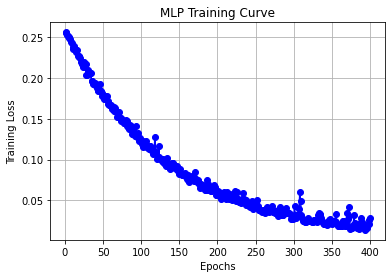

In [29]:
# Plot training loss curve
plt.plot(range(1, epochs + 1), loss_values, marker="o", linestyle="-", color="b")
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.title("MLP Training Curve")
plt.grid(True)
plt.show()

In [ ]:
from torchviz import make_dot

sample_input = torch.randn(1, input_size)

output = model(sample_input)
dot = make_dot(output, params=dict(model.named_parameters()))

dot.format = "png"
dot.render("neural_network")  
dot.view()